# Analysis of ProB backend over the 275 features set

In this note book we will explore the ProB native backend with default settings over the F275 feature set by employing decision trees and random forests.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/2020-01-10/prob-f275_unique.csv')
data.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274,Label0
0,100.0,0.06,0.19,0.02,0.105263,0.06,0.13,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,100.0,0.06,0.19,0.03,0.157895,-0.86,1.05,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,100.0,0.06,0.20,0.02,0.100000,0.07,0.12,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,100.0,0.06,0.20,0.03,0.150000,-0.87,1.06,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,100.0,0.06,0.20,0.04,0.200000,0.07,0.12,0.1,0.06,0.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Data insights

Firstly, we check how many positive and negative samples exist in the data.

In [2]:
sample_count = len(data)
positive = data[data["Label0"] == 1]
negative = data[data["Label0"] == 0]

print("We have %d samples in the dataset." % sample_count)
print("For %d of these, ProB is able to find a solution (%0.3f%%)" % (len(positive), len(positive)/sample_count))
print("For %d of these, ProB is _not_ able to find a solution (%0.3f%%)" % (len(negative), len(negative)/sample_count))

We have 106230 samples in the dataset.
For 95750 of these, ProB is able to find a solution (0.901%)
For 10480 of these, ProB is _not_ able to find a solution (0.099%)


Text(0, 0.5, '# Samples')

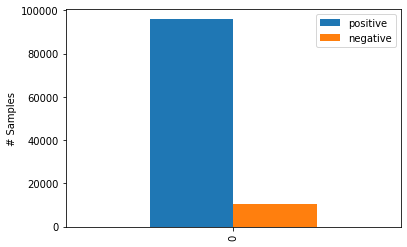

In [3]:
%matplotlib inline

class_balance = pd.DataFrame(data={"positive": [len(positive)], "negative": [len(negative)]})
class_balance_plot = class_balance.plot(kind="bar")
class_balance_plot.set_ylabel("# Samples")

Now we will inspect how often each feature is used in the data in the first place. Thus we can evaluate how much significance each evaluation over the subdomains has.

In [4]:
feature_uses = data[data > 1e-7].count() # For some values, 1e-7 is the lowest instead of 0.
rel_feature_uses = feature_uses/sample_count

fd = {}
for f in range(275):
    fd["Feature%d" % f] = [feature_uses[f]]
feature_data = pd.DataFrame(data=fd)
feature_data

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature265,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274
0,106230,106230,88271,88271,88271,77213,75919,88446,18776,106152,...,206,0,136,8,2,0,545,22,545,22


In [5]:
# We also calculate the relative amount of feature uses.
fd = {}
for f in range(275):
    fd["Feature%d" % f] = [rel_feature_uses[f]]
rel_feature_data = pd.DataFrame(data=fd)
rel_feature_data

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature265,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274
0,1.0,1.0,0.830942,0.830942,0.830942,0.726847,0.714666,0.83259,0.176749,0.999266,...,0.001939,0.0,0.00128,0.000075,0.000019,0.0,0.00513,0.000207,0.00513,0.000207


In [6]:
data.groupby("Label0").mean()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature265,Feature266,Feature267,Feature268,Feature269,Feature270,Feature271,Feature272,Feature273,Feature274
Label0,,,,,,,,,,,,,,,,,,,,,
0,10.416221,1.755806,0.340443,0.287682,0.559232,26.505638,1.454835,4.018525,0.390720,32.369717,...,0.003220,0.0,0.001240,0.000000,0.000000,0.0,0.008779,0.001622,0.003096,0.000620
1,11.663070,1.216280,0.478940,0.372724,0.711640,6.759599,2.100983,1.905493,0.191821,10.957896,...,0.001717,0.0,0.001285,0.000084,0.000021,0.0,0.007781,0.000115,0.003232,0.000089


## Training a Classifier

First, let's check the performance a decision tree or a random forest can reach on a designated train and test set.

### Prepare the training and test data

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.2)
train_x = train[train.columns[0:275]]
train_y = train["Label0"]

test_x = test[test.columns[0:275]]
test_y = test["Label0"]

In [8]:
from sklearn import metrics

def print_classifier_stats(classifier, test_x, test_y):
    train_acc = metrics.accuracy_score(tree.predict(train_x), train_y)
    test_acc = metrics.accuracy_score(tree.predict(test_x), test_y)
    print("Train accuracy: %0.3f; test accuracy: %0.3f" % (train_acc, test_acc))

    train_bacc = metrics.balanced_accuracy_score(tree.predict(train_x), train_y)
    test_bacc = metrics.balanced_accuracy_score(tree.predict(test_x), test_y)
    print("Train balanced accuracy: %0.3f; test balanced accuracy: %0.3f" % (train_bacc, test_bacc))

    train_prec = metrics.precision_score(tree.predict(train_x), train_y)
    test_prec = metrics.precision_score(tree.predict(test_x), test_y)
    print("Train precision: %0.3f; test precision: %0.3f" % (train_prec, test_prec))

    train_rec = metrics.recall_score(tree.predict(train_x), train_y)
    test_rec = metrics.recall_score(tree.predict(test_x), test_y)
    print("Train recall: %0.3f; test recall: %0.3f" % (train_rec, test_rec))

    train_f1 = metrics.f1_score(tree.predict(train_x), train_y)
    test_f1 = metrics.f1_score(tree.predict(test_x), test_y)
    print("Train F1: %0.3f; test F1: %0.3f" % (train_f1, test_f1))


### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight="balanced")

tree.fit(train_x, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [10]:
print_classifier_stats(tree, test_x, test_y)

Train accuracy: 0.989; test accuracy: 0.912
Train balanced accuracy: 0.950; test balanced accuracy: 0.756
Train precision: 0.988; test precision: 0.948
Train recall: 1.000; test recall: 0.954
Train F1: 0.994; test F1: 0.951


### Random Forest and Gini Importance

Next we will train a random forest with Gini Impurity and also calculate the respective gini importances of each feature.

In [11]:
from sklearn.ensemble import RandomForestClassifier

forest_0 = RandomForestClassifier(
    n_estimators=100, # 100 Trees.
    criterion="gini", # Using Gini index instead of "entropy"
    n_jobs=6, # Number of CPUs to use.
    bootstrap=False,
    max_features=0.7,
    random_state=124,
    class_weight="balanced")

forest_0.fit(train_x, train_y)


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

In [12]:
print_classifier_stats(forest_0, test_x, test_y)


Train accuracy: 0.989; test accuracy: 0.912
Train balanced accuracy: 0.950; test balanced accuracy: 0.756
Train precision: 0.988; test precision: 0.948
Train recall: 1.000; test recall: 0.954
Train F1: 0.994; test F1: 0.951


Let's map out the corresponding feature importances. We start by making use of the example code from [sk-learn](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [13]:
importances = forest_0.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_0.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 211 (0.103836)
2. feature 5 (0.057828)
3. feature 209 (0.054118)
4. feature 6 (0.021380)
5. feature 91 (0.021010)
6. feature 108 (0.020727)
7. feature 3 (0.020390)
8. feature 4 (0.020069)
9. feature 20 (0.020021)
10. feature 55 (0.019344)
11. feature 92 (0.019071)
12. feature 45 (0.018068)
13. feature 109 (0.017184)
14. feature 74 (0.016658)
15. feature 2 (0.015818)
16. feature 21 (0.015765)
17. feature 7 (0.015401)
18. feature 76 (0.015131)
19. feature 9 (0.014649)
20. feature 10 (0.012392)


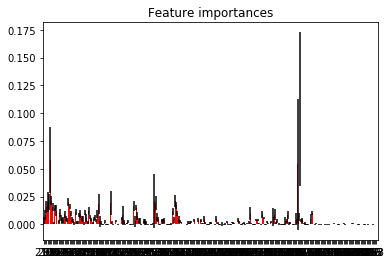

In [14]:
# Plot the feature importances of the forest
import matplotlib.pyplot as plt

plt.figure()
plt.title("Feature importances")
plt.bar(range(train_x.shape[1]), importances,
       color="r", yerr=std, align="center")
plt.xticks(range(train_x.shape[1]), indices)
plt.xlim([-1, train_x.shape[1]])
plt.show()

## Training on the full data set

For the feature evaluation it might be more of interest to not exclude the test set from the training data. We do not aim for a good predictor but instead for an analysis over the whole dataset.

In [15]:
X = data[data.columns[0:275]]
Y = data["Label0"]

forest = RandomForestClassifier(
    n_estimators=100, # 100 Trees.
    criterion="gini", # Using Gini index instead of "entropy"
    n_jobs=6, # Number of CPUs to use.
    bootstrap=False,
    max_features=0.7,
    random_state=123,
    class_weight="balanced")

forest.fit(X, Y)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [16]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 211 (0.124089)
2. feature 5 (0.062887)
3. feature 209 (0.038982)
4. feature 3 (0.023413)
5. feature 108 (0.022271)
6. feature 6 (0.021852)
7. feature 20 (0.019793)
8. feature 55 (0.018981)
9. feature 109 (0.018844)
10. feature 91 (0.018017)
11. feature 45 (0.017784)
12. feature 7 (0.015900)
13. feature 76 (0.015714)
14. feature 2 (0.015564)
15. feature 4 (0.015226)
16. feature 21 (0.014962)
17. feature 9 (0.014209)
18. feature 74 (0.013948)
19. feature 92 (0.013851)
20. feature 106 (0.012249)
21. feature 221 (0.011717)
22. feature 34 (0.011691)
23. feature 37 (0.011206)
24. feature 30 (0.010267)
25. feature 10 (0.010205)
26. feature 190 (0.010156)
27. feature 26 (0.009987)
28. feature 65 (0.009947)
29. feature 13 (0.009726)
30. feature 110 (0.009649)
31. feature 44 (0.009358)
32. feature 22 (0.009353)
33. feature 35 (0.009244)
34. feature 180 (0.008678)
35. feature 1 (0.008651)
36. feature 170 (0.008456)
37. feature 17 (0.007655)
38. feature 29 (0.007419)
39

In [17]:
%run features.py # Contains external code for assosiating the feature indices with their meaning.

<Figure size 432x288 with 0 Axes>

Add more information to each feature and collect category data.

In [18]:
# Print the feature ranking
print("Feature ranking:")

cat_count_top50 = {}
cat_count_top100 = {}
for f in range(100):
    cat = f275_category(indices[f])
    cat_count_top100[cat] = cat_count_top100.get(cat, 0) + 1
    if f < 50:
        cat_count_top50[cat] = cat_count_top50.get(cat, 0) + 1
    print("%3d. feature %3d (importance: %1.6f, rel. usage: %1.6f):  [%-11s]  %s" % (f + 1, indices[f], importances[indices[f]], rel_feature_uses[indices[f]], cat, f275_name(indices[f])))

Feature ranking:
  1. feature 211 (importance: 0.124089, rel. usage: 0.693891):  [Functions  ]  Functions or function applications per conjunct
  2. feature   5 (importance: 0.062887, rel. usage: 0.726847):  [Logic      ]  Conjunctions per conjunct
  3. feature 209 (importance: 0.038982, rel. usage: 0.548376):  [Functions  ]  Function applications per conjunct
  4. feature   3 (importance: 0.023413, rel. usage: 0.830942):  [Logic      ]  max negation depth per conjunct
  5. feature 108 (importance: 0.022271, rel. usage: 0.864417):  [Set theory ]  Set memberships per set inclusion op
  6. feature   6 (importance: 0.021852, rel. usage: 0.714666):  [Logic      ]  Disjunctions per conjunct
  7. feature  20 (importance: 0.019793, rel. usage: 0.800075):  [Equality   ]  Equality per conjunct
  8. feature  55 (importance: 0.018981, rel. usage: 0.177944):  [Arithmetic ]  Additions per conjunct
  9. feature 109 (importance: 0.018844, rel. usage: 0.676278):  [Set theory ]  Negative set membership

How many of the features of each category made it to the top 100?

In [19]:
cat_count_total = {}
for f in range(275):
    cat = f275_category(f)
    cat_count_total[cat] = cat_count_total.get(cat, 0) + 1

{'Logic': 11, 'Quantifiers': 9, 'Equality': 2, 'Identifiers': 23, 'Arithmetic': 29, 'Set theory': 57, 'Relations': 58, 'Functions': 33, 'Sequences': 49, 'Closure': 4}
{'Functions': 7, 'Logic': 9, 'Set theory': 11, 'Equality': 2, 'Arithmetic': 4, 'Identifiers': 11, 'Quantifiers': 4, 'Relations': 2}
{'Functions': 14, 'Logic': 10, 'Set theory': 27, 'Equality': 2, 'Arithmetic': 9, 'Identifiers': 18, 'Quantifiers': 8, 'Relations': 12}


### Category count in Top 100

In [20]:
for cat, count in cat_count_total.items():
    top100 = cat_count_top100.get(cat, 0)
    print("%-11s: %2d/%2d, %.3f%%" % (cat, top100, count, top100/count))

Logic      : 10/11, 0.909%
Quantifiers:  8/ 9, 0.889%
Equality   :  2/ 2, 1.000%
Identifiers: 18/23, 0.783%
Arithmetic :  9/29, 0.310%
Set theory : 27/57, 0.474%
Relations  : 12/58, 0.207%
Functions  : 14/33, 0.424%
Sequences  :  0/49, 0.000%
Closure    :  0/ 4, 0.000%


### Category count in Top 50

In [21]:
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    print("%-11s: %2d/%2d, %.3f%%" % (cat, top50, count, top50/count))

Logic      :  9/11, 0.818%
Quantifiers:  4/ 9, 0.444%
Equality   :  2/ 2, 1.000%
Identifiers: 11/23, 0.478%
Arithmetic :  4/29, 0.138%
Set theory : 11/57, 0.193%
Relations  :  2/58, 0.034%
Functions  :  7/33, 0.212%
Sequences  :  0/49, 0.000%
Closure    :  0/ 4, 0.000%


### Category counts Top 50 vs. Top 100

In [22]:
print("------------ %-5s %-5s Decline" % ("T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    top100 = cat_count_top100.get(cat, 0)
    print("%-11s: %.3f %.3f %.3f" % (cat, top100/count, top50/count, ((top100-top50)/top100) if top100>0 else 0))


------------ T100  T50   Decline
Logic      : 0.909 0.818 0.100
Quantifiers: 0.889 0.444 0.500
Equality   : 1.000 1.000 0.000
Identifiers: 0.783 0.478 0.389
Arithmetic : 0.310 0.138 0.556
Set theory : 0.474 0.193 0.593
Relations  : 0.207 0.034 0.833
Functions  : 0.424 0.212 0.500
Sequences  : 0.000 0.000 0.000
Closure    : 0.000 0.000 0.000


## Taking a look at permutation importance

While the Gini index captures the average gain of splitting on each feature in their respective position in the tree, the permutation importance is more robust against variable codependencies.

In [58]:
from sklearn.inspection import permutation_importance

perm_importances = permutation_importance(forest, X, Y, scoring='balanced_accuracy', n_repeats=5, n_jobs=1, random_state=1234)
perm_indices = perm_importances.importances_mean.argsort()[::-1]

In [59]:
# Print the feature ranking
print("Feature ranking:")

pcat_count_top50 = {}
pcat_count_top100 = {}
for f in range(100):
    cat = f275_category(perm_indices[f])
    pcat_count_top100[cat] = pcat_count_top100.get(cat, 0) + 1
    if f < 50:
        pcat_count_top50[cat] = pcat_count_top50.get(cat, 0) + 1
    print("%3d. feature %3d (importance: %1.6f, rel. usage: %1.6f):  [%-11s]  %s" % (f + 1, perm_indices[f], perm_importances.importances_mean[perm_indices[f]], rel_feature_uses[perm_indices[f]], cat, f275_name(perm_indices[f])))

Feature ranking:
  1. feature 211 (importance: 0.257536, rel. usage: 0.693891):  [Functions  ]  Functions or function applications per conjunct
  2. feature   5 (importance: 0.191051, rel. usage: 0.726847):  [Logic      ]  Conjunctions per conjunct
  3. feature   3 (importance: 0.092207, rel. usage: 0.830942):  [Logic      ]  max negation depth per conjunct
  4. feature  45 (importance: 0.047287, rel. usage: 0.491123):  [Arithmetic ]  Number of arithmetic ops
  5. feature  20 (importance: 0.043272, rel. usage: 0.800075):  [Equality   ]  Equality per conjunct
  6. feature  55 (importance: 0.042528, rel. usage: 0.177944):  [Arithmetic ]  Additions per conjunct
  7. feature  74 (importance: 0.028922, rel. usage: 0.985851):  [Set theory ]  Set inclusions
  8. feature  35 (importance: 0.023831, rel. usage: 0.473021):  [Identifiers]  #ids with semi-bounded domains per conjunct, explicit
  9. feature  76 (importance: 0.023702, rel. usage: 0.864417):  [Set theory ]  Set memberships
 10. featur

In [63]:
print("------------ %-5s %-5s Decline" % ("T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = pcat_count_top50.get(cat, 0)
    top100 = pcat_count_top100.get(cat, 0)
    print("%-11s: %.3f %.3f %.3f" % (cat, top100/count, top50/count, ((top100-top50)/top100) if top100>0 else 0))


------------ T100  T50   Decline
Logic      : 0.909 0.727 0.200
Quantifiers: 0.778 0.556 0.286
Equality   : 1.000 1.000 0.000
Identifiers: 0.826 0.478 0.421
Arithmetic : 0.310 0.103 0.667
Set theory : 0.421 0.228 0.458
Relations  : 0.259 0.052 0.800
Functions  : 0.394 0.152 0.615
Sequences  : 0.020 0.000 1.000
Closure    : 0.000 0.000 0.000


## Top 50/100 comparison between Gini Importance and Permutation Importance

In [70]:
print(".             Gini         Permutation")
print(".             %-5s %-5s  %-5s %-5s" % ("T100", "T50", "T100", "T50"))
for cat, count in cat_count_total.items():
    top50 = cat_count_top50.get(cat, 0)
    top100 = cat_count_top100.get(cat, 0)
    ptop50 = pcat_count_top50.get(cat, 0)
    ptop100 = pcat_count_top100.get(cat, 0)
    print("%-11s:  %.3f %.3f  %.3f %.3f" % (cat, top100/count, top50/count, ptop100/count, ptop50/count))


.             Gini         Permutation
.             T100  T50    T100  T50  
Logic      :  0.909 0.818  0.909 0.727
Quantifiers:  0.889 0.444  0.778 0.556
Equality   :  1.000 1.000  1.000 1.000
Identifiers:  0.783 0.478  0.826 0.478
Arithmetic :  0.310 0.138  0.310 0.103
Set theory :  0.474 0.193  0.421 0.228
Relations  :  0.207 0.034  0.259 0.052
Functions  :  0.424 0.212  0.394 0.152
Sequences  :  0.000 0.000  0.020 0.000
Closure    :  0.000 0.000  0.000 0.000


## Taking a look at the decision trees

In [71]:
def node_neg_class_ratio(tree_, node_id):
    # Code adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    leaf_ids = []

    children_right = tree_.children_right
    children_left = tree_.children_left

    stack = [(node_id, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
    neg_classifications = 0
    for id in leaf_ids:
        nprob, pprob = tree_.value[id][0][0]
        if nprob > pprob:
            neg_classifications += 1
    return neg_classifications/len(leaf_ids)



In [72]:
def gather_split_info(tree, feature):
    tree_ = tree.tree_
    argw = np.argwhere(tree_.feature == feature)
    if len(argw) < 1:
        return {} # Feature not used.
    fid = argw[0] # Find index of node for this feature.
    threshold = tree_.threshold[fid] # If value <= threshold then left child
    neg_rate = node_neg_class_ratio(tree_, fid)
    neg_left = node_neg_class_ratio(tree_, tree_.children_left[fid])
    neg_right = node_neg_class_ratio(tree_, tree_.children_right[fid])
    return {'threshold': threshold, 'unknown_rate': neg_rate, 'unknown_rate_left': neg_left, 'unknown_rate_right': neg_right}

def gather_tree_info(tree):
    tree_ = tree.tree_
    info = {}
    info["max_depth"] = tree_.max_depth
    info["splits"] = [gather_split_info(tree, f) for f in range(275)]
    return info

In [73]:
forest_trees = forest.estimators_

ftree_infos = []

for tree in forest_trees:
    ftree_infos.append(gather_tree_info(tree))

For the top 50 features, what are the thresholds and where do they lead?
The tendency values range from -100 to 100 (including) and show how many trees in the forest lead to an answer if the value is below (-100) or above (+100) their respective threshold.

In [74]:
for fid in indices[0:50]:
    print("->", f275_name(fid))
    thresholds = []
    num_left_lower = 0
    num_right_lower = 0
    for tinfo in ftree_infos:
        split_info = tinfo['splits'][fid]
        if split_info == {}: continue # Feature not used in this tree.
        thresholds.append(split_info['threshold'])
        if split_info['unknown_rate'] > split_info['unknown_rate_left']:
            num_left_lower += 1
        else:
            num_right_lower += 1
    thresholds.sort()
    avg_threshold = sum(thresholds)/len(ftree_infos)
    med_threshold = thresholds[len(ftree_infos)//2]
    print("  avg threshold: %.3f (min %.3f, max %.3f, median %.3f)" % (avg_threshold, thresholds[0], thresholds[-1], med_threshold))
    print("  %.2f%% of trees observe higher solvability if below threshold, %.2f%% above" % (100*num_left_lower/len(ftree_infos), 100*num_right_lower/len(ftree_infos)))
    tendency = num_right_lower - num_left_lower
    print("  tendency of %s values for more solvable constraints (tendency value: %d)" % ("higher" if tendency > 0 else "lower", tendency))


-> Functions or function applications per conjunct
  avg threshold: 0.894 (min 0.055, max 1.500, median 1.015)
  88.00% of trees observe higher solvability if below threshold, 12.00% above
  tendency of lower values for more solvable constraints (tendency value: -76)
-> Conjunctions per conjunct
  avg threshold: 4.536 (min -0.751, max 11.929, median 6.857)
  40.00% of trees observe higher solvability if below threshold, 60.00% above
  tendency of higher values for more solvable constraints (tendency value: 20)
-> Function applications per conjunct
  avg threshold: 0.307 (min 0.018, max 0.784, median 0.239)
  71.00% of trees observe higher solvability if below threshold, 29.00% above
  tendency of lower values for more solvable constraints (tendency value: -42)
-> max negation depth per conjunct
  avg threshold: 0.723 (min 0.004, max 2.500, median 0.583)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lower values for more solvable constraints

We see that certain features, while having high relevancy for classification, display a tendency around 0. 
But what does that mean regarding their relevancy? Naively it look as the feature is not a language-subset in which the backend performs worse but rather that unknown-results are related to the rest of the predicate. Depending on the random data subset the respective tree was trained on, the threshold might split into better or worse samples.

### Display of tendencies per category

In [75]:


sklearn.inspection.permutation_importance(estimator, X, y, scoring=None, n_repeats=5, n_jobs=None, random_state=None)

NameError: name 'sklearn' is not defined

In [100]:
def calc_feature_stats(feature_ids):
    """Returns a dictionary over the given feature ids as keys.
    For each feature, another dictionary with the following structure is returned:
        {'rank-gini': rank_gini_importance, 'rank-permutation': rank_permutation_importance,
         'tendency': tendency, 
         'thresholds': {'list': thresholds, 
                        'avg': avg_threshold,
                        'median': median_threshold},
         'num_lower_below_threshold': num_left_lower,
         'num_lower_above_threshold': num_right_lower}
    The entry might be an empty dictionary if the corresponding feature was not used.
    """
    stats = {}
    for fid in feature_ids:
        rank_gini = np.argwhere(indices == fid)[0][0]+1
        rank_perm = np.argwhere(perm_indices == fid)[0][0]+1
        thresholds = []
        num_left_lower = 0
        num_right_lower = 0
        for tinfo in ftree_infos:
            split_info = tinfo['splits'][fid]
            if split_info == {}: continue # Feature not used in this tree.
            thresholds.append(split_info['threshold'])
            if split_info['unknown_rate'] > split_info['unknown_rate_left']:
                num_left_lower += 1
            else:
                num_right_lower += 1
        thresholds.sort()
        if (len(thresholds) == 0):
            stats[fid] = {}
            continue
        avg_threshold = sum(thresholds)/len(ftree_infos)
        med_threshold = thresholds[len(thresholds)//2]
        tendency = num_right_lower - num_left_lower
        stats[fid] = {'rank-gini': rank_gini, 'rank-permutation': rank_perm,
                      'tendency': tendency, 'thresholds': {'list': thresholds, 'avg': avg_threshold, 'median': med_threshold},
                      'num_lower_below_threshold': num_left_lower, 'num_lower_above_threshold': num_right_lower}
    return stats

def print_feature_stats(feature_stats):
    for fid in sorted(feature_stats.keys()):
        stats = feature_stats.get(fid)
        if stats == {}:
            print(f275_name(fid))
            print("  feature is not used.")
            continue
        print(f275_name(fid))
        print("  - Gini rank no.", stats['rank-gini'], "  Perm. rank no.", stats['rank-permutation'], "-")
        print("  avg threshold: %.3f (min %.3f, max %.3f, median %.3f)" % (stats['thresholds']['avg'], stats['thresholds']['list'][0], stats['thresholds']['list'][-1], stats['thresholds']['median']))
        tendency = stats['tendency']
        num_left_lower = stats['num_lower_below_threshold']
        num_right_lower = stats['num_lower_above_threshold']
        print("  %.2f%% of trees observe higher solvability if below threshold, %.2f%% above" % (100*num_left_lower/len(ftree_infos), 100*num_right_lower/len(ftree_infos)))
        print("  tendency of %s values for more solvable constraints (tendency value: %d)" % ("higher" if tendency > 0 else "lower", tendency))

In [101]:
def print_feature_group_stats(features, category_name):
    print("#", category_name)
    fs = calc_feature_stats(features)
    tendencies = [fs[s]['tendency'] for s in fs.keys() if fs[s] != {}]
    print("  Average tendency:", sum(tendencies)/len(tendencies))
    print_feature_stats(fs) 

In [102]:
print_feature_group_stats(range(11), "Logic")

# Logic
  Average tendency: 14.363636363636363
Number of top-level conjuncts
  - Gini rank no. 87   Perm. rank no. 275 -
  avg threshold: 18.730 (min 1.500, max 111.500, median 6.500)
  43.00% of trees observe higher solvability if below threshold, 57.00% above
  tendency of higher values for more solvable constraints (tendency value: 14)
Max conjunct depth per conjunct
  - Gini rank no. 35   Perm. rank no. 67 -
  avg threshold: 1.087 (min 0.020, max 3.500, median 1.250)
  19.00% of trees observe higher solvability if below threshold, 81.00% above
  tendency of higher values for more solvable constraints (tendency value: 62)
number of negations per conjunct
  - Gini rank no. 14   Perm. rank no. 10 -
  avg threshold: 0.827 (min 0.004, max 2.846, median 0.633)
  69.00% of trees observe higher solvability if below threshold, 31.00% above
  tendency of lower values for more solvable constraints (tendency value: -38)
max negation depth per conjunct
  - Gini rank no. 4   Perm. rank no. 3 -
 

In [103]:
print_feature_group_stats(range(11, 20), "Quantifiers") 

# Quantifiers
  Average tendency: -5.222222222222222
number of boolean conversions per conjunct
  - Gini rank no. 157   Perm. rank no. 86 -
  avg threshold: 0.266 (min 0.020, max 1.000, median 0.250)
  55.00% of trees observe higher solvability if below threshold, 42.00% above
  tendency of lower values for more solvable constraints (tendency value: -13)
Number of quantifiers
  - Gini rank no. 83   Perm. rank no. 125 -
  avg threshold: 2.645 (min 0.500, max 38.500, median 1.500)
  73.00% of trees observe higher solvability if below threshold, 27.00% above
  tendency of lower values for more solvable constraints (tendency value: -46)
Universal quantifiers per conjunct
  - Gini rank no. 29   Perm. rank no. 22 -
  avg threshold: 0.303 (min 0.007, max 1.500, median 0.208)
  39.00% of trees observe higher solvability if below threshold, 61.00% above
  tendency of higher values for more solvable constraints (tendency value: 22)
Existential quantifiers per conjunct
  - Gini rank no. 49   Perm

In [104]:
print_feature_group_stats(range(20, 22), "Equality") 

# Equality
  Average tendency: -4.0
Equality per conjunct
  - Gini rank no. 7   Perm. rank no. 5 -
  avg threshold: 1.030 (min 0.054, max 12.500, median 0.500)
  44.00% of trees observe higher solvability if below threshold, 56.00% above
  tendency of higher values for more solvable constraints (tendency value: 12)
Inequality per conjunct
  - Gini rank no. 16   Perm. rank no. 17 -
  avg threshold: 0.591 (min 0.089, max 0.971, median 0.686)
  60.00% of trees observe higher solvability if below threshold, 40.00% above
  tendency of lower values for more solvable constraints (tendency value: -20)


In [105]:
print_feature_group_stats(range(22, 45), "Identifiers") 

# Identifiers
  Average tendency: 4.869565217391305
Number of identifiers
  - Gini rank no. 32   Perm. rank no. 33 -
  avg threshold: 6.445 (min 1.500, max 54.500, median 2.500)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lower values for more solvable constraints (tendency value: -6)
#identifier relations
  - Gini rank no. 52   Perm. rank no. 69 -
  avg threshold: 2.665 (min 0.500, max 26.500, median 0.500)
  41.00% of trees observe higher solvability if below threshold, 59.00% above
  tendency of higher values for more solvable constraints (tendency value: 18)
#ids with bounded domains, symbolic
  - Gini rank no. 85   Perm. rank no. 60 -
  avg threshold: 2.805 (min 1.000, max 14.000, median 1.000)
  44.00% of trees observe higher solvability if below threshold, 56.00% above
  tendency of higher values for more solvable constraints (tendency value: 12)
#ids with bounded domains, explicit
  - Gini rank no. 117   Perm. rank no. 94 -
  avg 

In [106]:
print_feature_group_stats(range(45, 74), "Arithmetic") 

# Arithmetic
  Average tendency: -5.206896551724138
Number of arithmetic ops
  - Gini rank no. 11   Perm. rank no. 4 -
  avg threshold: 1.430 (min 0.500, max 4.500, median 1.500)
  53.00% of trees observe higher solvability if below threshold, 47.00% above
  tendency of lower values for more solvable constraints (tendency value: -6)
Additions
  - Gini rank no. 91   Perm. rank no. 117 -
  avg threshold: 4.445 (min 0.500, max 58.000, median 2.000)
  62.00% of trees observe higher solvability if below threshold, 38.00% above
  tendency of lower values for more solvable constraints (tendency value: -24)
Multiplications
  - Gini rank no. 115   Perm. rank no. 101 -
  avg threshold: 2.290 (min 0.500, max 9.500, median 1.500)
  56.00% of trees observe higher solvability if below threshold, 44.00% above
  tendency of lower values for more solvable constraints (tendency value: -12)
Divisions
  - Gini rank no. 176   Perm. rank no. 116 -
  avg threshold: 2.335 (min 0.500, max 24.000, median 1.500)

In [107]:
print_feature_group_stats(range(74, 131), "Set theory") 

# Set theory
  Average tendency: 16.12962962962963
Set inclusions
  - Gini rank no. 18   Perm. rank no. 7 -
  avg threshold: 5.855 (min 0.500, max 59.500, median 3.000)
  50.00% of trees observe higher solvability if below threshold, 50.00% above
  tendency of lower values for more solvable constraints (tendency value: 0)
Set operations
  - Gini rank no. 98   Perm. rank no. 132 -
  avg threshold: 3.420 (min 0.500, max 40.000, median 1.500)
  31.00% of trees observe higher solvability if below threshold, 69.00% above
  tendency of higher values for more solvable constraints (tendency value: 38)
Set memberships
  - Gini rank no. 13   Perm. rank no. 9 -
  avg threshold: 4.775 (min 0.500, max 29.500, median 2.500)
  54.00% of trees observe higher solvability if below threshold, 46.00% above
  tendency of lower values for more solvable constraints (tendency value: -8)
Negated set memberships
  - Gini rank no. 40   Perm. rank no. 59 -
  avg threshold: 2.695 (min 0.500, max 22.000, median 1.5

In [108]:
print_feature_group_stats(range(131, 189), "Relations") 

# Relations
  Average tendency: 12.839285714285714
Number of relations
  - Gini rank no. 126   Perm. rank no. 240 -
  avg threshold: 1.230 (min 0.500, max 6.500, median 0.500)
  43.00% of trees observe higher solvability if below threshold, 57.00% above
  tendency of higher values for more solvable constraints (tendency value: 14)
Number of rel ops
  - Gini rank no. 51   Perm. rank no. 239 -
  avg threshold: 2.720 (min 0.500, max 55.500, median 1.500)
  29.00% of trees observe higher solvability if below threshold, 71.00% above
  tendency of higher values for more solvable constraints (tendency value: 42)
Number of general relations
  - Gini rank no. 122   Perm. rank no. 238 -
  avg threshold: 1.625 (min 0.500, max 6.000, median 1.000)
  52.00% of trees observe higher solvability if below threshold, 48.00% above
  tendency of lower values for more solvable constraints (tendency value: -4)
Number of total relations
  - Gini rank no. 238   Perm. rank no. 237 -
  avg threshold: 0.065 (min

In [109]:
print_feature_group_stats(range(189, 222), "Functions") 

# Functions
  Average tendency: -7.909090909090909
Number of functions
  - Gini rank no. 58   Perm. rank no. 257 -
  avg threshold: 3.010 (min 0.500, max 21.500, median 1.500)
  57.00% of trees observe higher solvability if below threshold, 43.00% above
  tendency of lower values for more solvable constraints (tendency value: -14)
Function applications
  - Gini rank no. 26   Perm. rank no. 13 -
  avg threshold: 3.595 (min 0.500, max 26.500, median 2.500)
  37.00% of trees observe higher solvability if below threshold, 63.00% above
  tendency of higher values for more solvable constraints (tendency value: 26)
General, partial function
  - Gini rank no. 116   Perm. rank no. 256 -
  avg threshold: 0.915 (min 0.500, max 6.000, median 0.500)
  30.00% of trees observe higher solvability if below threshold, 70.00% above
  tendency of higher values for more solvable constraints (tendency value: 40)
General, total function
  - Gini rank no. 77   Perm. rank no. 255 -
  avg threshold: 3.325 (min 

In [110]:
print_feature_group_stats(range(222, 271), "Sequences") 

# Sequences
  Average tendency: 0.06896551724137931
Number of sequences and injective sequences
  - Gini rank no. 145   Perm. rank no. 177 -
  avg threshold: 1.075 (min 0.500, max 4.000, median 0.500)
  64.00% of trees observe higher solvability if below threshold, 36.00% above
  tendency of lower values for more solvable constraints (tendency value: -28)
Number of seq ops
  - Gini rank no. 152   Perm. rank no. 176 -
  avg threshold: 0.940 (min 0.500, max 3.000, median 0.500)
  38.00% of trees observe higher solvability if below threshold, 58.00% above
  tendency of higher values for more solvable constraints (tendency value: 20)
Number of sequences
  - Gini rank no. 143   Perm. rank no. 175 -
  avg threshold: 1.400 (min 0.500, max 9.500, median 1.000)
  63.00% of trees observe higher solvability if below threshold, 37.00% above
  tendency of lower values for more solvable constraints (tendency value: -26)
Number of injective sequences
  feature is not used.
`size` calls
  feature is n

In [111]:
print_feature_group_stats(range(271, 275), "Closure and Iterate")

# Closure and Iterate
  Average tendency: 36.5
number of closures
  - Gini rank no. 188   Perm. rank no. 190 -
  avg threshold: 0.610 (min 0.500, max 2.500, median 0.500)
  16.00% of trees observe higher solvability if below threshold, 76.00% above
  tendency of higher values for more solvable constraints (tendency value: 60)
number of iterations
  - Gini rank no. 231   Perm. rank no. 189 -
  avg threshold: 0.230 (min 0.500, max 0.500, median 0.500)
  15.00% of trees observe higher solvability if below threshold, 31.00% above
  tendency of higher values for more solvable constraints (tendency value: 16)
number of closures per conjunct
  - Gini rank no. 170   Perm. rank no. 234 -
  avg threshold: 0.277 (min 0.038, max 1.500, median 0.062)
  24.00% of trees observe higher solvability if below threshold, 74.00% above
  tendency of higher values for more solvable constraints (tendency value: 50)
number of iterations per conjunct
  - Gini rank no. 228   Perm. rank no. 155 -
  avg threshold:

### Gather information over the learned rules with inTrees

In [129]:
%run intrees.py

In [118]:
extracted_rules = extract_rules(forest)

How many rules did we collect?

In [119]:
rule_count = 0
for tree in forest.estimators_:
    rule_set = extracted_rules[tree]
    rule_count += len(rule_set)
rule_count

791399

How many conditions can we collect?

In [120]:
extracted_conds = extract_conditions(forest, max_depth=15)

In [121]:
cond_count = 0
for tree in forest.estimators_:
    conds = extracted_conds[tree]
    cond_count += len(conds)
cond_count

152193

In [122]:
avg_rule_length = 0
avg_rule_error = 0
avg_rule_freq = 0

all_rules = []

for tree in forest.estimators_:
    rule_set = extracted_rules[tree]
    for rule in rule_set:
        rl = rule_length(tree, rule)
        re = rule_error(tree, rule)
        rf = rule_frequency(tree, rule)
        avg_rule_length += rl
        avg_rule_error += re
        avg_rule_freq += rf
        all_rules += [(rule, rf, re, rl, tree)]

avg_rule_error /= rule_count
avg_rule_length /= rule_count
avg_rule_freq /= rule_count

print("Avg frequency:", avg_rule_freq)
print("Avg error:", avg_rule_error)
print("Avg length:", avg_rule_length)

Avg frequency: 0.000700126150410644
Avg error: 0.13790871193250362
Avg length: 22.538872300824238


In [123]:
for ranked_rule in sorted(all_rules, key = lambda r: (1/r[1], 1/r[3], r[2]))[0:10]:
    print("Rule:", ranked_rule[0])
    print("Freq.: %f, error: %f, length: %d" % (ranked_rule[1], ranked_rule[2], ranked_rule[3]))
    print()

Rule: (((0, 211, 1.0145833492279053, False), (5986, 5, 19.416666984558105, False), (12576, 3, 0.75, True), (12577, 38, 0.8544973433017731, False)), 1)
Freq.: 0.173745, error: 0.130349, length: 4

Rule: (((0, 211, 1.0145833492279053, False), (5752, 5, 19.416666984558105, False), (12402, 3, 0.75, True), (12403, 38, 0.8544973433017731, False)), 1)
Freq.: 0.173745, error: 0.130349, length: 4

Rule: (((0, 211, 1.0145833492279053, True), (1, 65, 0.0444664042443037, True), (2, 108, 0.9160798192024231, True), (3, 7, 0.02198067680001259, False), (1255, 209, 0.23904761672019958, True), (1256, 13, 0.49390244483947754, True), (1257, 93, 4.799999952316284, True), (1258, 199, 1.5, True), (1259, 97, 1.0833333134651184, True), (1260, 94, 0.6631205677986145, True), (1261, 138, 6.5, True), (1262, 144, 0.5, True), (1263, 255, 0.1339285746216774, True), (1264, 91, 1.2970588207244873, True), (1265, 28, 4.5, True), (1266, 164, 1.4166666865348816, False)), 0)
Freq.: 0.097017, error: 0.060487, length: 16

Rul

In [124]:
def pretty_print_rule(rule):
    cond, target = rule
    for (_, fid, thresh, leq) in cond:
        comp_sign = "<=" if leq else ">"
        print("# %3d: %s %s %.3f" % (fid, f275_name(fid), comp_sign, thresh))
    print("=> %d" % target)

In [125]:
# Prints the first rule containing one of the features 90, 119, or 120
for ranked_rule in sorted(all_rules, key = lambda r: (1/r[1], 1/r[3], r[2])):
    rule = ranked_rule[0]
    has_found = False
    for (_, id, _, _) in rule[0]:
        if id in [119, 120, 90] and rule[1] == 0:
            pretty_print_rule(rule)
            has_found = True
    if has_found: break
        

# 211: Functions or function applications per conjunct <= 1.015
#  55: Additions per conjunct <= 0.006
#  92: Negative set memberships per conjunct <= 0.953
# 209: Function applications per conjunct <= 0.239
#  93: Subsets per conjunct <= 2.938
#  94: Strict subsets per conjunct <= 0.663
#  47: Multiplications <= 4.500
#  99: Intersections per conjunct <= 0.944
# 165: Domain restrictionper conjunct <= 0.536
#  22: Number of identifiers <= 23.500
#   1: Max conjunct depth per conjunct > 0.044
#  20: Equality per conjunct <= 12.500
# 247: `permutation` calls per conjunct <= 0.134
# 170: Rel ops per conjunct <= 1.392
# 144: prj1 <= 0.500
#  68: Modulo ratio of arithmetic ops <= 0.833
#  13: Universal quantifiers per conjunct <= 0.481
# 199: Lambda-expression <= 1.500
# 119: Number of set comprehensions per set inclusion op <= 0.414
#  30: Identifiers per conjunct > 0.410
# 239: Sequences per conjunct <= 0.293
#  22: Number of identifiers > 2.500
# 201: General, total function per conjunct